In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
expr = pd.read_csv('./Data/TestData.tsv', sep='\t', index_col=0)

In [3]:
expr.head()

,EGFR,RB1,TP53,CDKN2A,MYC,RB2,TP54
SampleID,,,,,,,
Sample_1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
Sample_2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
Sample_3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
Sample_4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
Sample_5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [4]:
print(expr.iloc[0:4,0:4])
X_train = expr.values[:,0:(expr.shape[1]-1)]
X_train = np.log(X_train + 1)
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = expr.values[:,expr.shape[1]-1]
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

           EGFR   RB1  TP53  CDKN2A
SampleID                           
Sample_1  12.08  2.92  2.80   81.40
Sample_2  12.38  3.53  3.22   46.17
Sample_3  14.02  2.59  4.01   72.80
Sample_4  17.67  6.75  2.63   39.81

This data set contains 200 samples

Dimensions of the  data set: 
(200, 6) (200,)


In [5]:
dist = np.square(euclidean_distances(X_train, X_train))
rho = [sorted(dist[i])[1] for i in range(dist.shape[0])]
print(dist[0:4, 0:4])
print('\n')
print(rho[0:4])

[[0.         0.38078923 0.14689306 1.10781041]
 [0.38078923 0.         0.36275208 0.45216431]
 [0.14689306 0.36275208 0.         1.16898235]
 [1.10781041 0.45216431 1.16898235 0.        ]]


[0.08003243174357877, 0.048622209992217336, 0.0778421998248575, 0.031672749591457716]


In [6]:
# For each row of Euclidean distance matrix (dist_row) compute probability in high dimensions (1D array)
def prob_high_dim(sigma, dist_row):
    d = dist[dist_row] - rho[dist_row]
    d[d < 0] = 0
    return np.exp(- d / sigma)

# Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
def k(prob):
    return np.power(2, np.sum(prob))

#     Solve equation k_of_sigma(sigma) = fixed_k with respect to sigma by the binary search algorithm
def sigma_binary_search(k_of_sigma, fixed_k):
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

In [7]:
N_NEIGHBOR = 15
prob = np.zeros((n,n))
sigma_array = []
for dist_row in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(round(np.mean(sigma_array),3)))

Sigma binary search finished 100 of 200 cells
Sigma binary search finished 200 of 200 cells

Mean sigma = 0.03


In [8]:
#P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
P = (prob + np.transpose(prob)) / 2

In [9]:
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(round(a,3)) + " and b = " + str(round(b,3)))

Hyperparameters a = 1.121 and b = 1.057


In [10]:
a = 1
b = 1

In [11]:
# Compute matrix of probabilities q_ij in low-dimensional space
def prob_low_dim(Y):
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances
# Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities and coordinates of low-dimensional embeddings
def CE(P, Y):
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

# Compute the gradient of Cross-Entropy (CE)
def CE_gradient(P, Y):
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact = np.expand_dims(a * P * (1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [12]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 50       # 200

np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 50)
y = model.fit_transform(np.log(X_train + 1))
#y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))

CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CE_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
    plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    plt.savefig('./UMAP_Plots/UMAP_iter_' + str(i) + '.png')
    plt.close()
    
    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(round(CE_current,3)) + " after " + str(i) + " iterations")

Running Gradient Descent: 

Cross-Entropy = 1.714 after 0 iterations
Cross-Entropy = 0.11 after 10 iterations
Cross-Entropy = 0.067 after 20 iterations
Cross-Entropy = 0.062 after 30 iterations
Cross-Entropy = 0.058 after 40 iterations


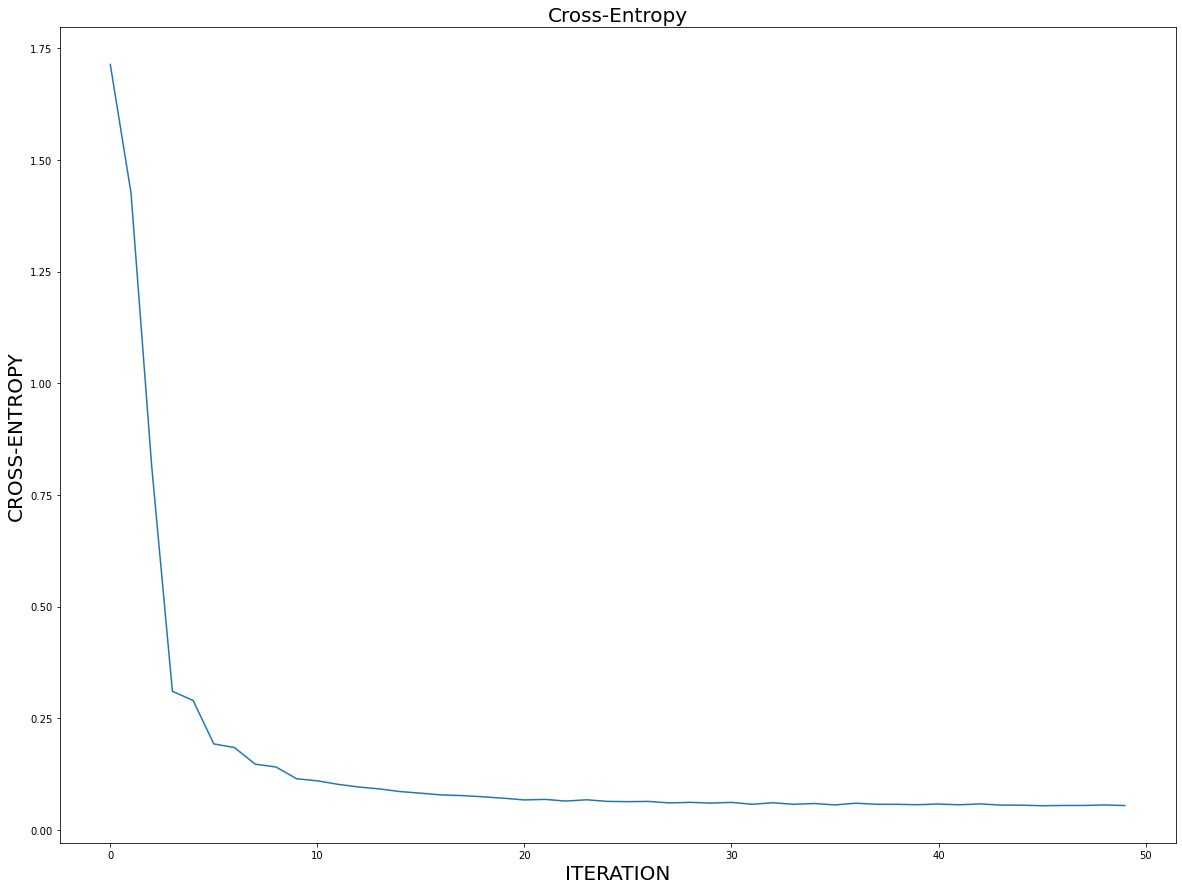

In [13]:
plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

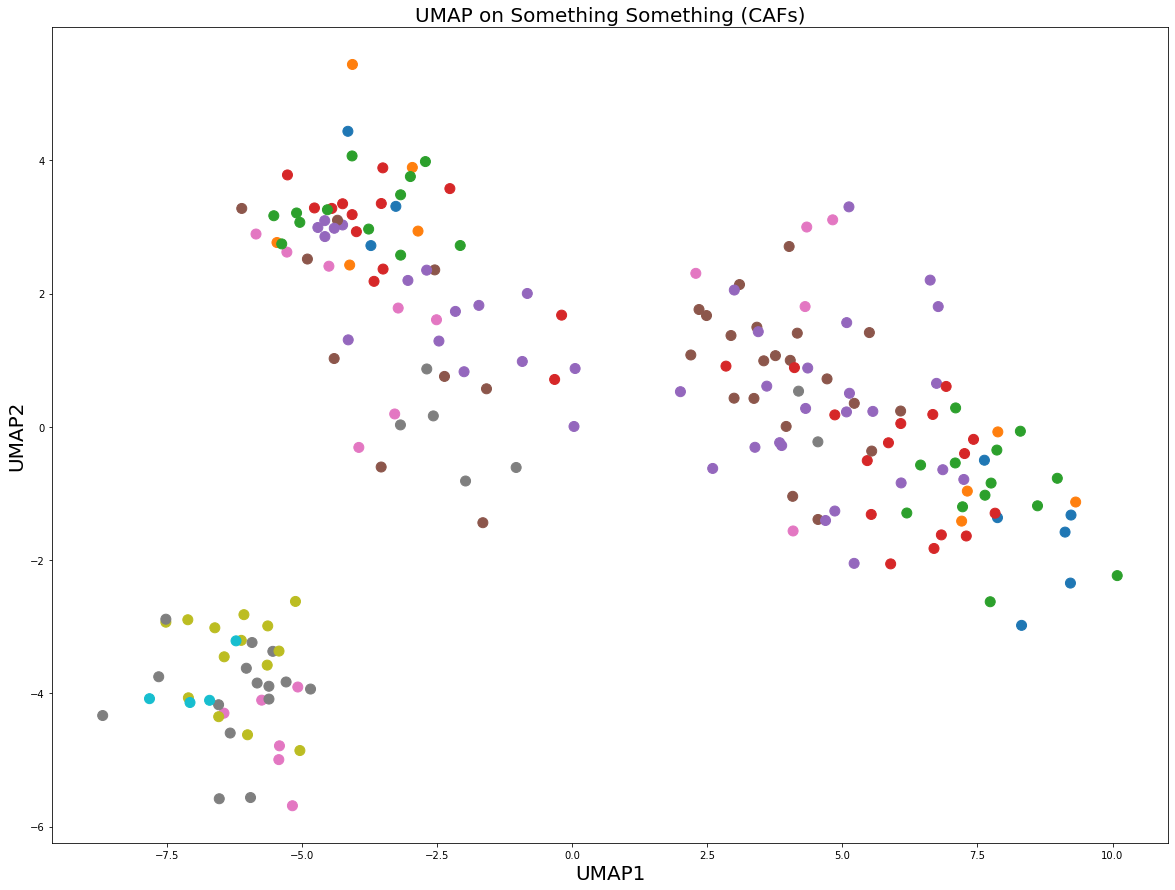

In [17]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 100)
plt.title("UMAP on Something Something (CAFs)", fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()